In [1]:
import tensorflow as tf

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [5]:
X_train.shape

(48000, 28, 28)

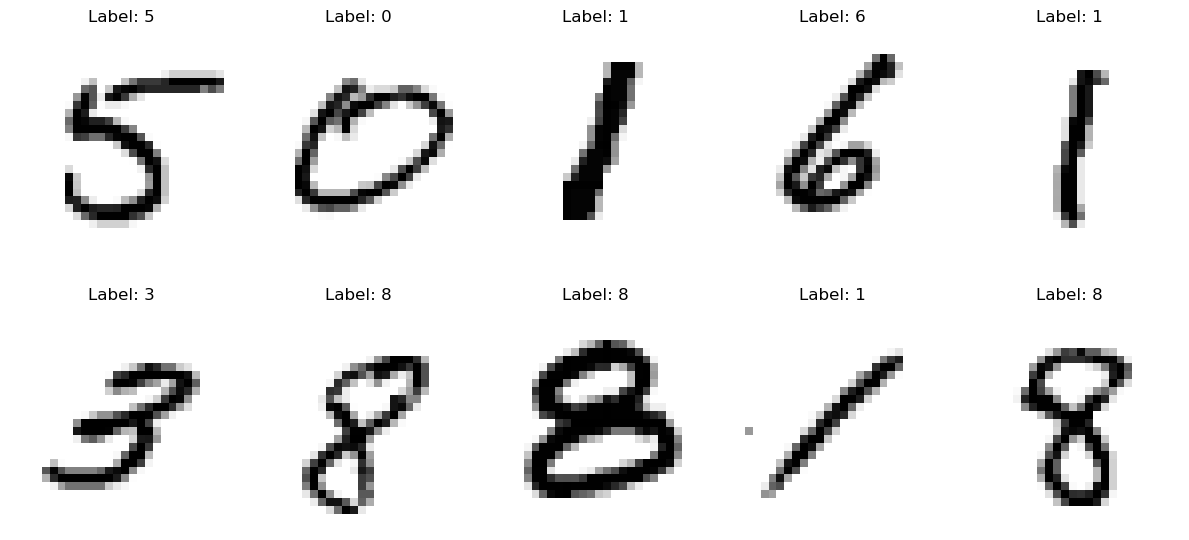

In [54]:
import matplotlib.pyplot as plt

# Plot a few sample images from X_train
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(X_train[i], cmap='binary')
    axes[row, col].set_title(f'Label: {y_train[i]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [55]:
tf.keras.backend.clear_session()

In [56]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 10)                3010      
                                                                 
Total params: 328810 (1.25 MB)
Trainable params: 328810 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [59]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2116 - accuracy: 0.9362 - val_loss: 0.1230 - val_accuracy: 0.9647
Epoch 2/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0893 - accuracy: 0.9723 - val_loss: 0.1041 - val_accuracy: 0.9679
Epoch 3/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0615 - accuracy: 0.9807 - val_loss: 0.0898 - val_accuracy: 0.9743
Epoch 4/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0457 - accuracy: 0.9856 - val_loss: 0.1117 - val_accuracy: 0.9709
Epoch 5/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0367 - accuracy: 0.9878 - val_loss: 0.1002 - val_accuracy: 0.9729
Epoch 6/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.1005 - val_accuracy: 0.9776
Epoch 7/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0262 - accuracy: 0.9914 - val_loss: 0.0906 - val_accuracy:

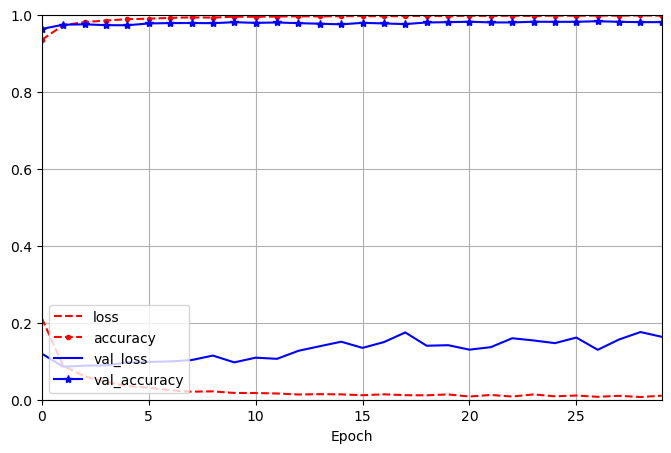

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  
plt.show()

In [14]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 560us/step - loss: 0.1570 - accuracy: 0.9803


[0.15704889595508575, 0.9803000092506409]

# Learning Rate Finder

Now let's implement a learning rate finder that grows the learning rate exponentially and plots the loss. This technique helps us find the optimal learning rate for training.

In [15]:
class LearningRateFinder:
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.learning_rates = []
        self.best_loss = float('inf')
        
    def on_batch_end(self, batch, logs):
        # Get the current learning rate
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(lr)
        
        # Get the current loss
        loss = logs.get('loss')
        self.losses.append(loss)
        
        # Stop if loss is getting too high
        if loss > self.best_loss * 4:
            self.model.stop_training = True
            return
        
        if loss < self.best_loss:
            self.best_loss = loss
            
        # Increase learning rate exponentially
        lr *= self.lr_mult
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
    
    def find(self, X_train, y_train, start_lr=1e-7, end_lr=10, batch_size=32, epochs=1):
        # Calculate learning rate multiplier
        num_batches = epochs * len(X_train) // batch_size
        self.lr_mult = (end_lr / start_lr) ** (1.0 / num_batches)
        
        # Reset the model weights
        original_weights = self.model.get_weights()
        
        # Set initial learning rate
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, start_lr)
        
        # Create a custom callback
        class LRFinderCallback(tf.keras.callbacks.Callback):
            def __init__(self, finder):
                self.finder = finder
                
            def on_batch_end(self, batch, logs=None):
                self.finder.on_batch_end(batch, logs or {})
        
        callback = LRFinderCallback(self)
        
        # Train the model
        self.model.fit(X_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      callbacks=[callback],
                      verbose=0)
        
        # Restore original weights
        self.model.set_weights(original_weights)
        
        return self.learning_rates, self.losses
    
    def plot(self, skip_start=10, skip_end=5):
        """Plot the learning rate vs loss"""
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Skip some points at the beginning and end
        lrs = self.learning_rates[skip_start:-skip_end] if skip_end > 0 else self.learning_rates[skip_start:]
        losses = self.losses[skip_start:-skip_end] if skip_end > 0 else self.losses[skip_start:]
        
        plt.figure(figsize=(10, 6))
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate (log scale)')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder')
        plt.grid(True)
        plt.show()
        
        # Find the learning rate with minimum loss
        min_loss_idx = np.argmin(losses)
        optimal_lr = lrs[min_loss_idx]
        print(f"Minimum loss: {min(losses):.6f}")
        print(f"Learning rate at minimum loss: {optimal_lr:.2e}")
        
        # Suggest a learning rate (typically 1/10th of the optimal)
        suggested_lr = optimal_lr / 10
        print(f"Suggested learning rate: {suggested_lr:.2e}")
        
        return optimal_lr, suggested_lr

In [16]:
# Create a new model for the learning rate finder
tf.keras.backend.clear_session()

lr_finder_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile with a basic optimizer (we'll change the learning rate dynamically)
lr_finder_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])

Running learning rate finder...


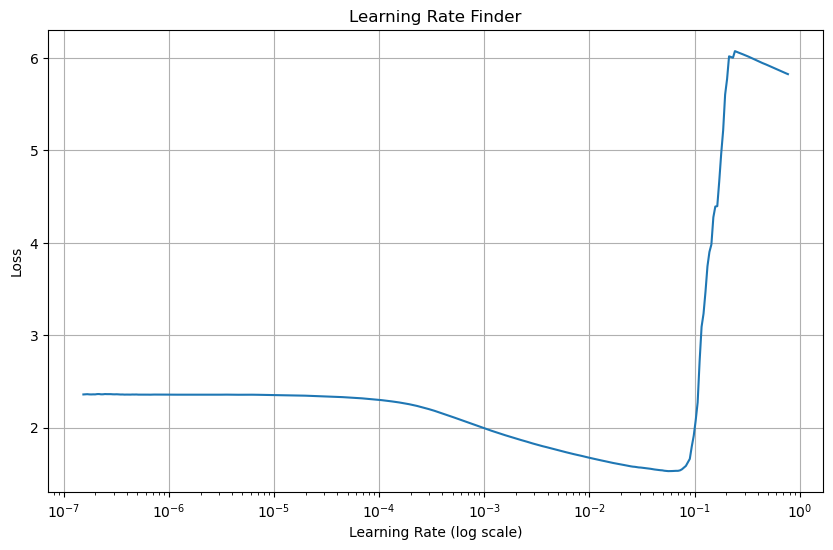

Minimum loss: 1.530423
Learning rate at minimum loss: 5.61e-02
Suggested learning rate: 5.61e-03


In [17]:
# Initialize and run the learning rate finder
lr_finder = LearningRateFinder(lr_finder_model)

print("Running learning rate finder...")
learning_rates, losses = lr_finder.find(X_train, y_train, 
                                       start_lr=1e-7, 
                                       end_lr=1, 
                                       batch_size=128, 
                                       epochs=1)

# Plot the results
optimal_lr, suggested_lr = lr_finder.plot()

In [18]:
# Now let's train a model with the suggested learning rate
tf.keras.backend.clear_session()

optimized_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Use the suggested learning rate
optimized_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(learning_rate=suggested_lr),
                       metrics=["accuracy"])

print(f"Training model with suggested learning rate: {suggested_lr:.2e}")

# Train the model
history_optimized = optimized_model.fit(X_train, y_train, epochs=30,
                                       validation_data=(X_valid, y_valid),
                                       verbose=1)

Training model with suggested learning rate: 5.61e-03
Epoch 1/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2503 - accuracy: 0.9263 - val_loss: 0.1874 - val_accuracy: 0.9476
Epoch 2/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1476 - accuracy: 0.9588 - val_loss: 0.1417 - val_accuracy: 0.9614
Epoch 3/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1213 - accuracy: 0.9647 - val_loss: 0.1520 - val_accuracy: 0.9621
Epoch 4/30
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1101 - accuracy: 0.9703 - val_loss: 0.1238 - val_accuracy: 0.9666
Epoch 5/30
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1026 - accuracy: 0.9723 - val_loss: 0.1454 - val_accuracy: 0.9666
Epoch 6/30
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0850 - accuracy: 0.9769 - val_loss: 0.1365 - val_accuracy: 0.9688
Epoch 7/30
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0859

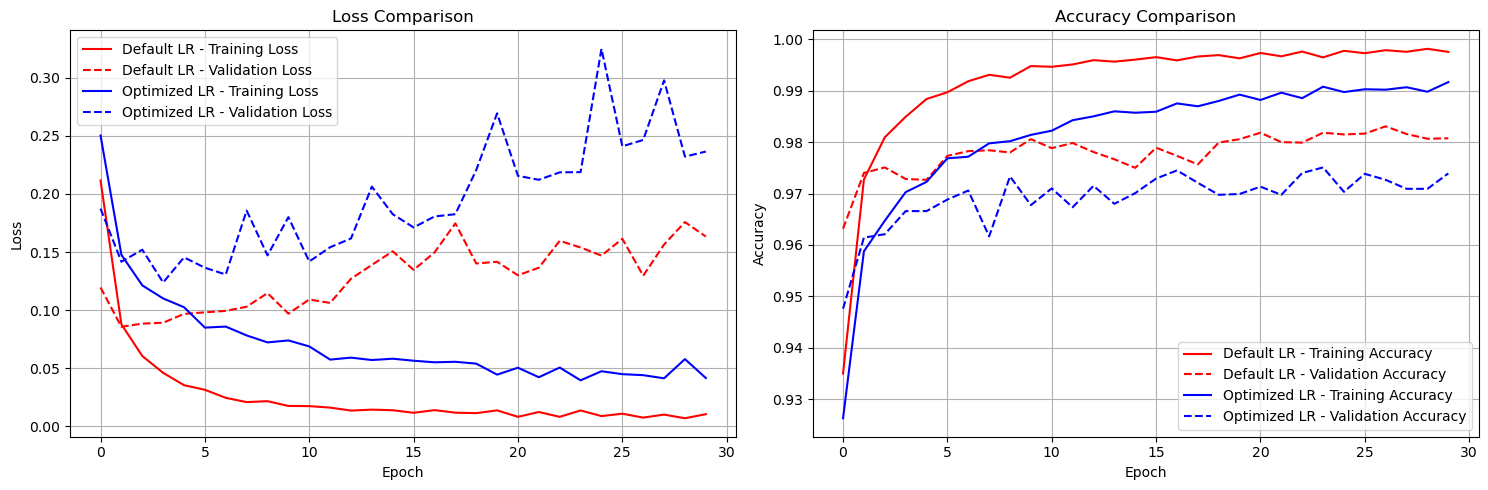

Original model performance:
Test Loss: 0.1570, Test Accuracy: 0.9803

Optimized learning rate model performance:
Test Loss: 0.2224, Test Accuracy: 0.9743

Improvement in accuracy: -0.0060


In [19]:
# Compare the training histories
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss comparison
ax1.plot(history.history['loss'], 'r-', label='Default LR - Training Loss')
ax1.plot(history.history['val_loss'], 'r--', label='Default LR - Validation Loss')
ax1.plot(history_optimized.history['loss'], 'b-', label='Optimized LR - Training Loss')
ax1.plot(history_optimized.history['val_loss'], 'b--', label='Optimized LR - Validation Loss')
ax1.set_title('Loss Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy comparison
ax2.plot(history.history['accuracy'], 'r-', label='Default LR - Training Accuracy')
ax2.plot(history.history['val_accuracy'], 'r--', label='Default LR - Validation Accuracy')
ax2.plot(history_optimized.history['accuracy'], 'b-', label='Optimized LR - Training Accuracy')
ax2.plot(history_optimized.history['val_accuracy'], 'b--', label='Optimized LR - Validation Accuracy')
ax2.set_title('Accuracy Comparison')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Evaluate both models
print("Original model performance:")
original_results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {original_results[0]:.4f}, Test Accuracy: {original_results[1]:.4f}")

print("\nOptimized learning rate model performance:")
optimized_results = optimized_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {optimized_results[0]:.4f}, Test Accuracy: {optimized_results[1]:.4f}")

print(f"\nImprovement in accuracy: {optimized_results[1] - original_results[1]:.4f}")

In [60]:
tf.keras.backend.clear_session()

In [62]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=1, max_value=5, default=2)
    n_neurons = hp.Int('n_neurons', min_value=50, max_value=300, step=50, default=100)
    learning_rate = hp.Float('learning_rate ', min_value=1e-5, max_value=1e-1, sampling='log')
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [64]:
random_search_tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_mnist_tuning',
    project_name='mnist_tuning'
)
random_search_tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 00m 30s]
val_accuracy: 0.9162500103314718

Best val_accuracy So Far: 0.9790555437405905
Total elapsed time: 00h 07m 56s


In [65]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]
best_hyperparameters = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

In [68]:
best_hyperparameters.values

{'n_hidden': 1,
 'n_neurons': 300,
 'learning_rate ': 0.0007291148313021565,
 'optimizer': 'adam'}

In [69]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 10)                3010      
                                                                 
Total params: 238510 (931.68 KB)
Trainable params: 238510 (931.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.0963 - val_accuracy: 0.9758
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0858 - val_accuracy: 0.9796
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.0850 - val_accuracy: 0.9805
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0076 - accuracy: 0.9974 - val_loss: 0.0918 - val_accuracy: 0.9783
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0897 - val_accuracy: 0.9802
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.0916 - val_accuracy: 0.9795
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0919 - val_accuracy:

In [71]:
best_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 444us/step - loss: 0.0914 - accuracy: 0.9810


[0.09136038273572922, 0.9810000061988831]